<a href="https://colab.research.google.com/github/jyj1206/BDA_9th_Pandas/blob/main/5%EC%A3%BC%EC%B0%A8_%EA%B2%B0%EC%B8%A1%EC%B9%982.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 불러오기
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
# 데이터 불러오기
data = sns.load_dataset("healthexp")

In [ ]:
data.shape

(274, 4)

In [ ]:
# 결측값 만들기
np.random.seed(42)

# 데이터 복사
data_with_missing = data.copy()

missing_rate = 0.05 # 결측치 퍼센트

# 전체 데이터에서 무작위로 결측값을 삽입할 위치 선택
n_total = data_with_missing.size
n_missing = int(n_total * missing_rate)

# 무작위 인덱스 생성
missing_indices = np.random.choice(n_total, n_missing, replace=False)

# 결측치 무작위로 만들기
rows, cols = np.unravel_index(missing_indices, data_with_missing.shape)
for row, col in zip(rows, cols):
  data_with_missing.iloc[row, col] = np.nan

In [ ]:
# 결측치 확인
data_with_missing.isna().sum()

,0
Year,11
Country,11
Spending_USD,17
Life_Expectancy,15


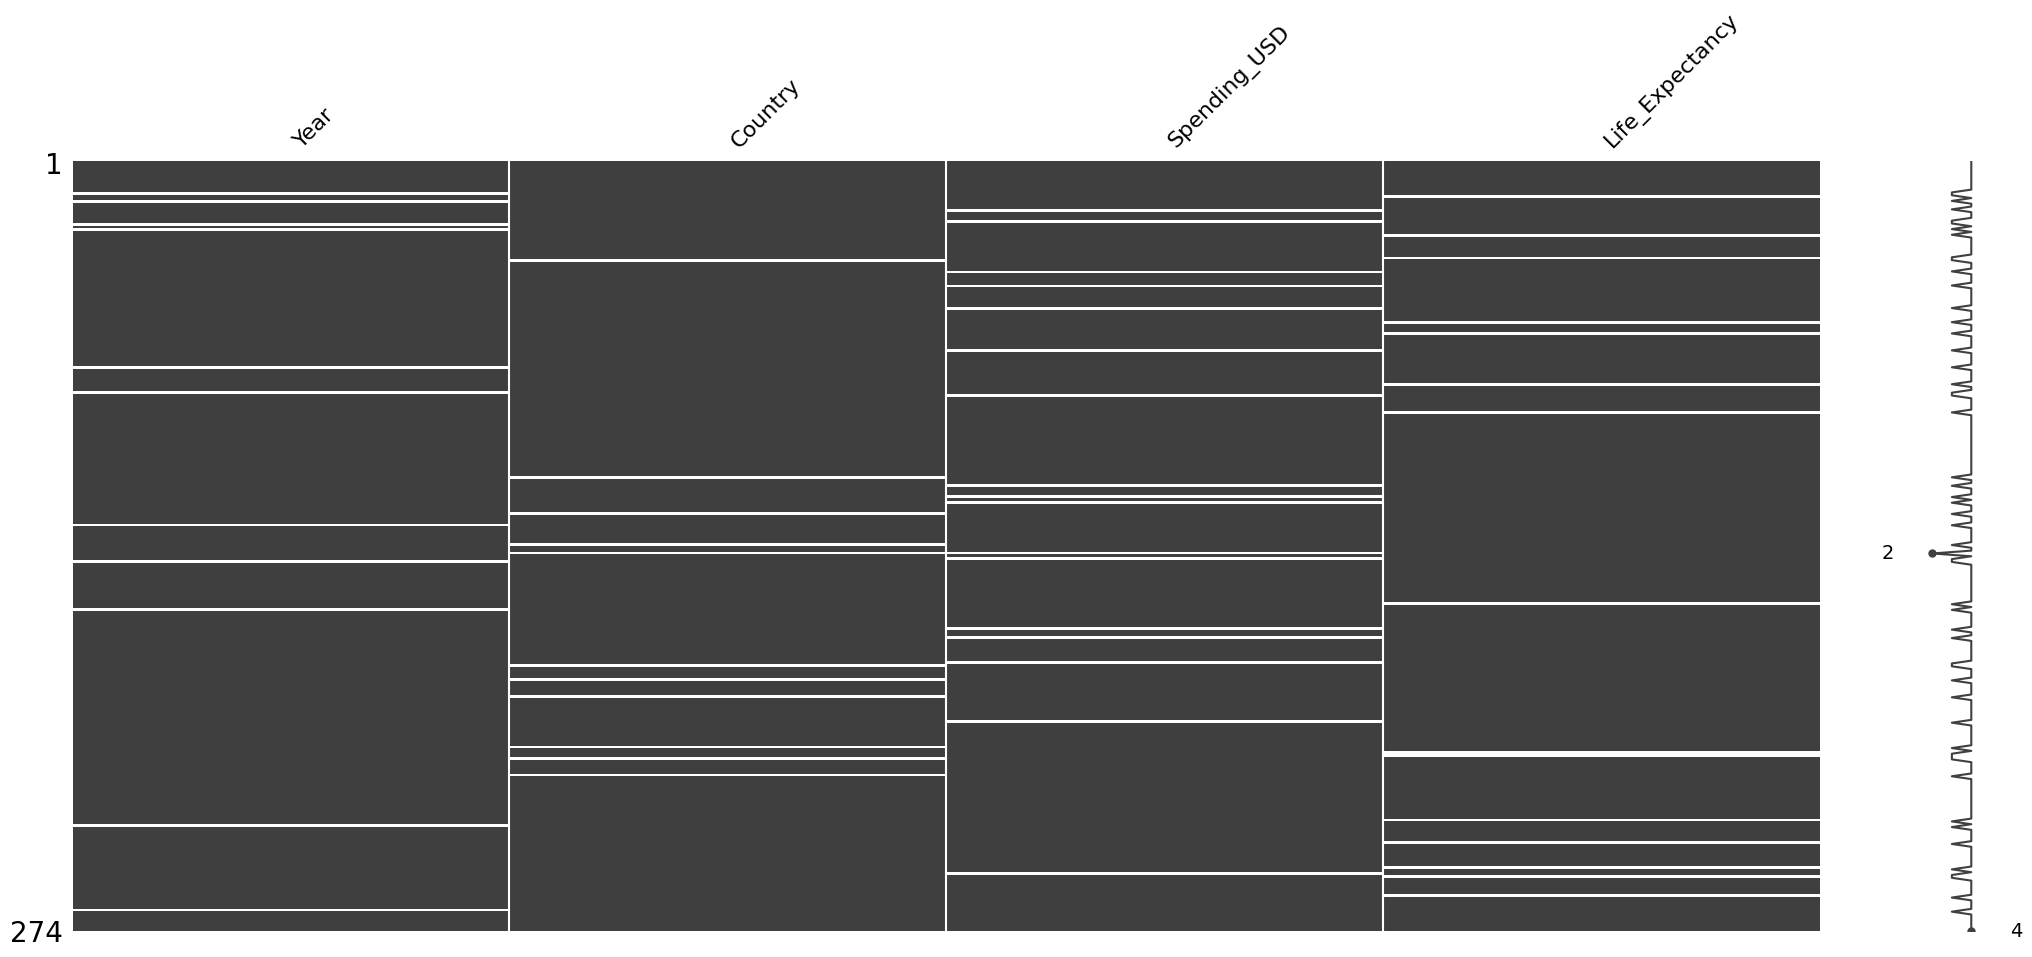

In [ ]:
msno.matrix(data_with_missing)
plt.show()

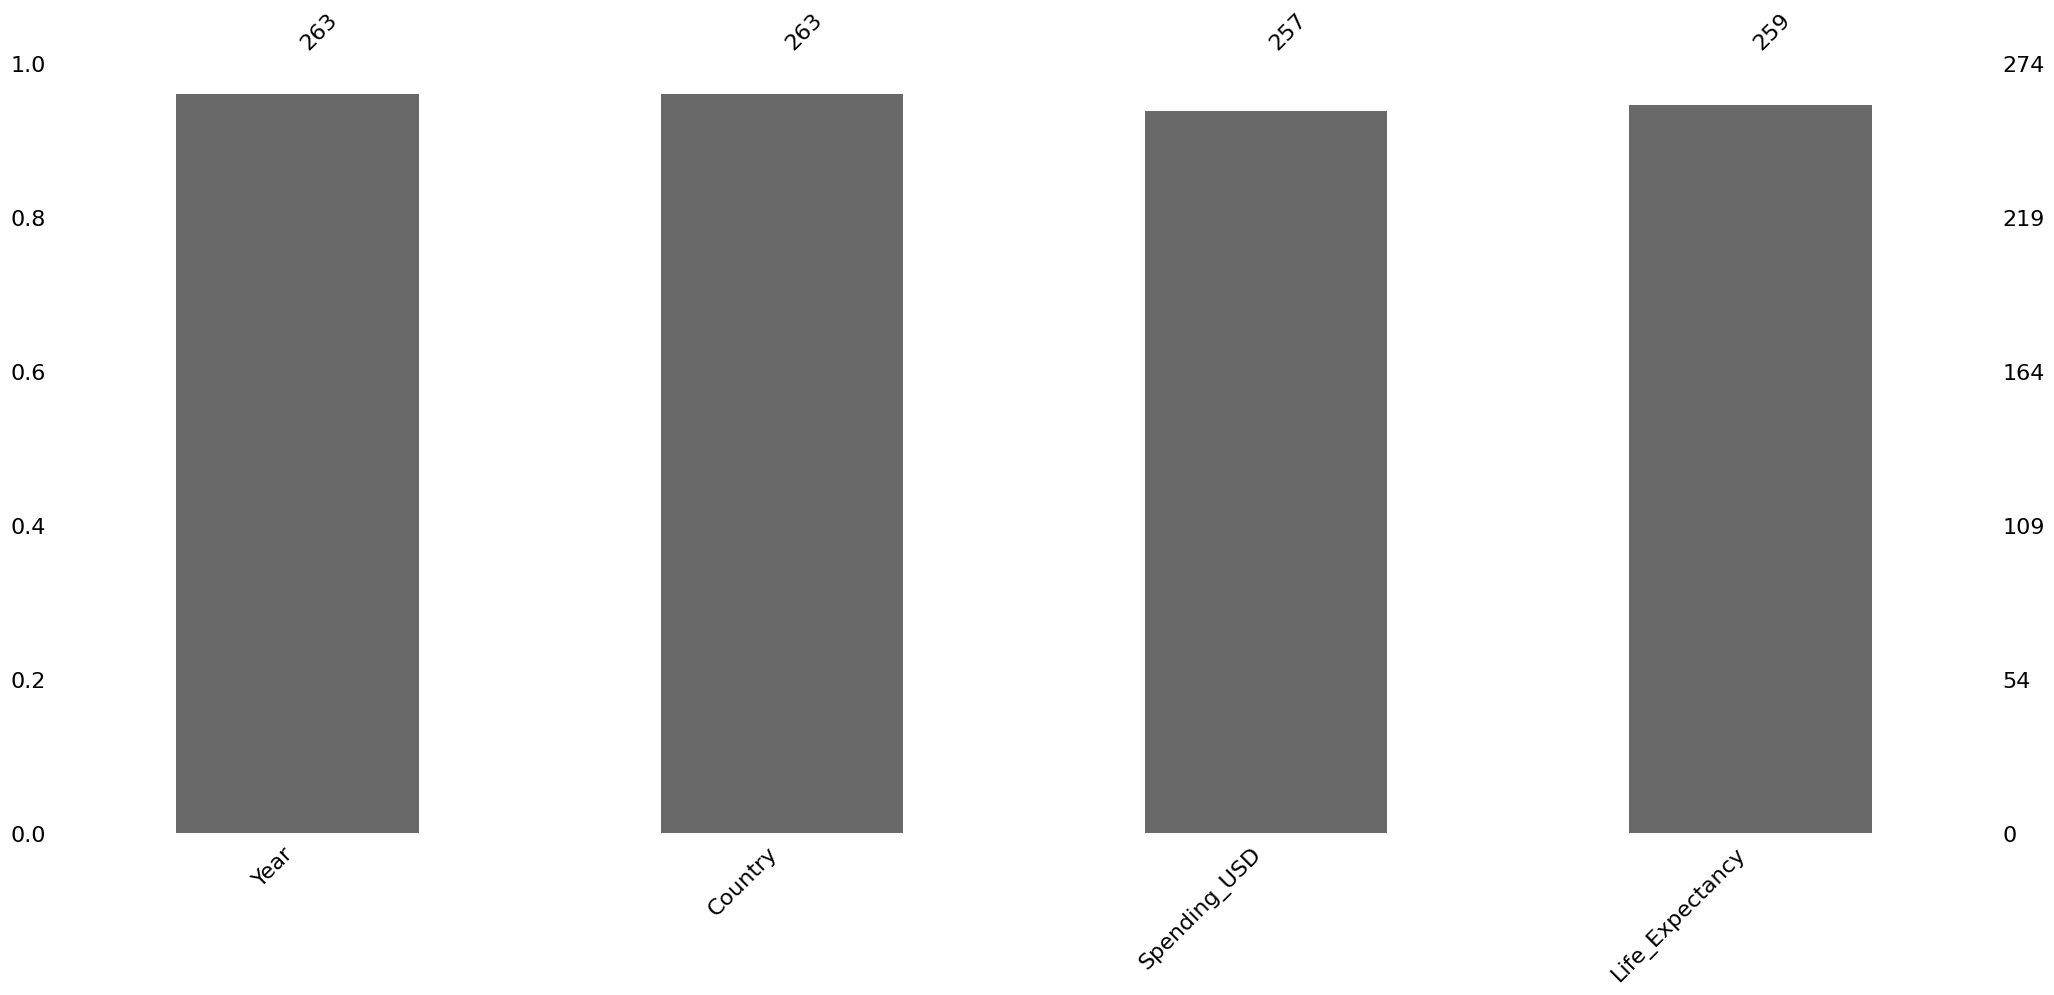

In [ ]:
msno.bar(data_with_missing)
plt.show()

In [ ]:
data_with_missing.dropna(how='all')

,Year,Country,Spending_USD,Life_Expectancy
0,1970.0,Germany,252.311,70.6
1,1970.0,France,192.143,72.2
2,1970.0,Great Britain,123.993,71.9
3,1970.0,Japan,150.437,72.0
4,1970.0,USA,326.961,70.9
...,...,...,...,...
269,2020.0,Germany,6938.983,81.1
270,2020.0,France,5468.418,82.3
271,2020.0,Great Britain,5018.700,80.4
272,2020.0,Japan,4665.641,84.7


In [ ]:
# 결측치 index 찾기
index = data_with_missing.index[data_with_missing.isna().any(axis=1)]

In [ ]:
# 모두 0으로 대치
data_with_missing.iloc[index, :].fillna(0).head(5)

,Year,Country,Spending_USD,Life_Expectancy
11,0.0,Japan,185.390,73.2
12,1972.0,USA,397.097,0.0
14,0.0,Japan,205.778,73.4
17,1974.0,Japan,0.000,73.7
21,1975.0,Japan,0.000,74.3


In [ ]:
# 평균값으로 대치
data_with_missing.iloc[index, :].fillna(data_with_missing['Life_Expectancy'].mean()).head(5)

,Year,Country,Spending_USD,Life_Expectancy
11,77.887645,Japan,185.390000,73.200000
12,1972.000000,USA,397.097000,77.887645
14,77.887645,Japan,205.778000,73.400000
17,1974.000000,Japan,77.887645,73.700000
21,1975.000000,Japan,77.887645,74.300000


In [ ]:
# 시간에 따라 전의 데이터로 대치
data_with_missing.fillna(method='bfill').head(5)

<ipython-input-16-b71c09bef44d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_with_missing.fillna(method='bfill').head(5)


,Year,Country,Spending_USD,Life_Expectancy
0,1970.0,Germany,252.311,70.6
1,1970.0,France,192.143,72.2
2,1970.0,Great Britain,123.993,71.9
3,1970.0,Japan,150.437,72.0
4,1970.0,USA,326.961,70.9


In [ ]:
# 결측치 방법에 따른 성능 테스트
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer

In [ ]:
# 데이터 불러오기
data = sns.load_dataset("healthexp")

- 독립 변수 : Year, Country, Spending_USD
- 종속 변수 : Life_Expectancy

목표 : Life_Expectancy의 결측치를 만들고 변화에 따른 모델링 성능확인

In [ ]:
# 결측값 만들기
np.random.seed(42)

data_with_missing = data.copy()

missing_rate = 0.1
n_missing = int(len(data_with_missing) * missing_rate)

missing_indices = np.random.choice(len(data_with_missing), n_missing, replace=False)

print("추가된 결측값 개수 : ", len(missing_indices))

data_with_missing.loc[missing_indices, 'Spending_USD'] = np.nan

추가된 결측값 개수 :  27


In [ ]:
# 확인
data_with_missing.isna().sum()

,0
Year,0
Country,0
Spending_USD,27
Life_Expectancy,0


In [ ]:
# 결측치 처리 함수 정의
def drop_na(df, column):
    return df.dropna(subset=[column])

def mean_imputation(df, column):
    df_filled = df.copy()
    df_filled[column] = df_filled[column].fillna(df_filled[column].mean())
    return df_filled

def linear_interpolation(df, column):
    df_filled = df.copy()
    df_filled[column] = df_filled[column].interpolate(method='linear')
    return df_filled

def knn_imputation(df, column, n_neighbors=5):
    df_filled = df.copy()

    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_filled[[column]] = imputer.fit_transform(df_filled[[column]])

    return df_filled

In [ ]:
# 결과 저장
methods = {
    'Drop NA': drop_na,
    'Mean Imputation':mean_imputation,
    'Linear Interpolation':linear_interpolation,
    'Knn Imputation' : knn_imputation
}
results = pd.DataFrame(columns=['Method', 'Dataset', 'MSE', 'R2'])

In [ ]:
column = 'Spending_USD'

# 모델 학습 및 평가
for method_name, impute_func in methods.items():
    # 결측치 처리
    data_filled = impute_func(data_with_missing, column)

    # Feature와 Target 분리
    X = data_filled.drop(columns=column)
    y = data_filled[column]

    # 범주형 변수 더미 인코딩 (drop_first=True로 첫 번째 레벨 제거)
    X = pd.get_dummies(X, drop_first=True)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 모델 학습
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Train/Test 평가
    for dataset_name, X_data, y_data in (['Train', X_train, y_train], ['Test', X_test, y_test]):
        y_pred = model.predict(X_data)

        # 평가 지표 계산
        mse = mean_squared_error(y_data, y_pred)
        r2 = r2_score(y_data, y_pred)

        # 결과 저장
        result_now = pd.DataFrame({
            'Method': [method_name],
            'Dataset': [dataset_name],
            'MSE': [mse],
            'R2': [r2]
        })
        results = pd.concat([results, result_now], ignore_index=True)

# 결과 출력
results

<ipython-input-145-8ca3caf1211e>:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_now], ignore_index=True)


,Method,Dataset,MSE,R2
0,Drop NA,Train,1.008259e+04,0.997793
1,Drop NA,Test,7.043155e+04,0.985579
2,Mean Imputation,Train,1.184271e+04,0.997469
3,Mean Imputation,Test,3.112351e+06,-0.498801
4,Linear Interpolation,Train,1.184271e+04,0.997469
5,Linear Interpolation,Test,2.068646e+06,0.582370
6,Knn Imputation,Train,1.184271e+04,0.997469
7,Knn Imputation,Test,3.112351e+06,-0.498801


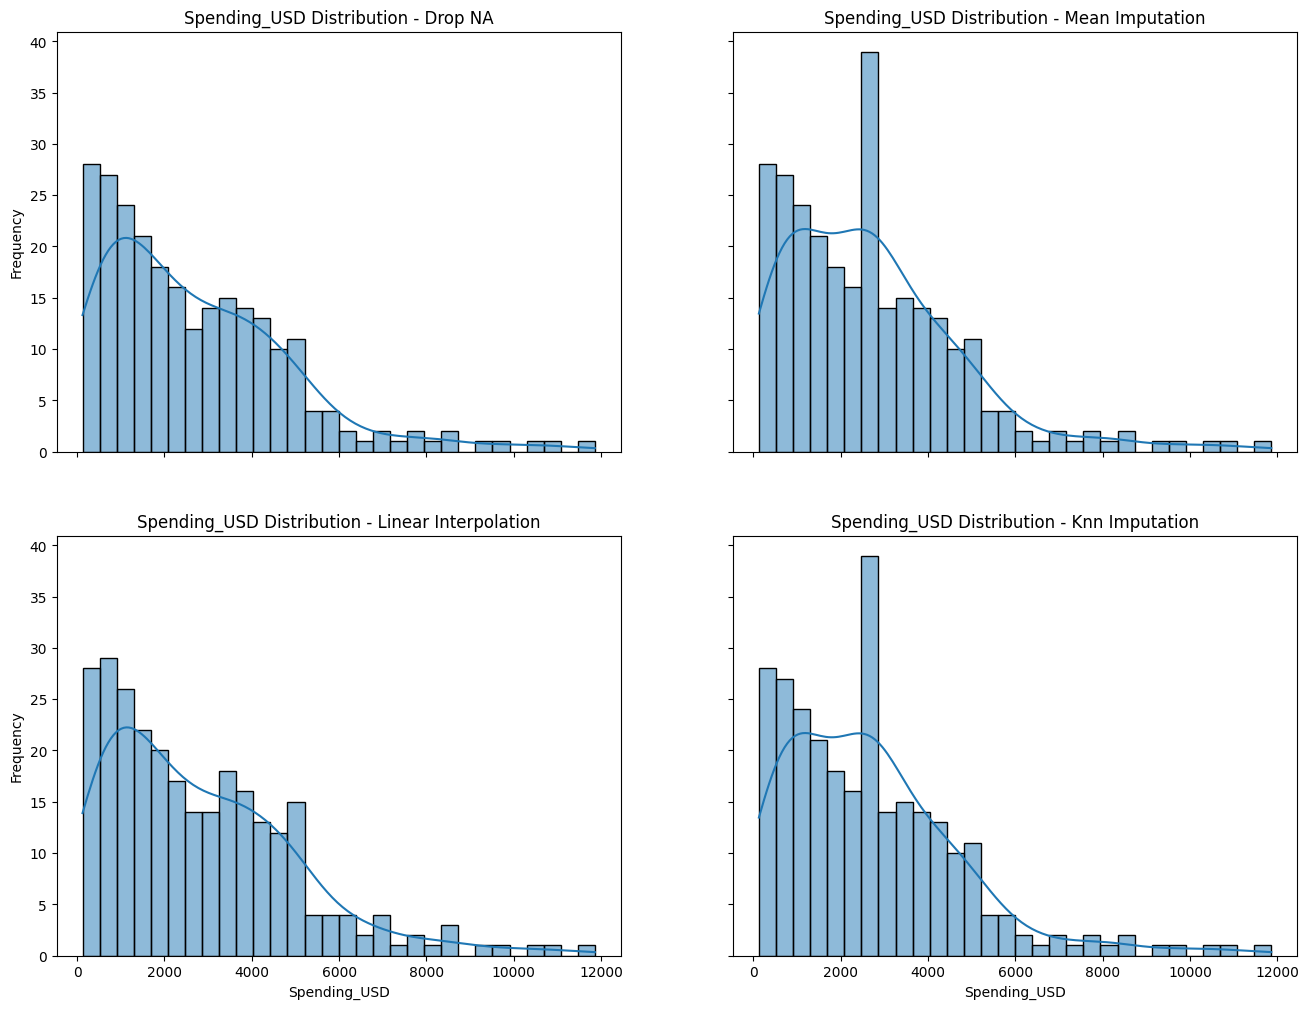

In [ ]:
# 시각적으로 어떤 식으로 결측치가 보간 된 걸까?
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(16,12), sharex= True, sharey=True)
axes = axes.flatten()

for ax,(method_name, impute_func) in zip (axes, methods.items()):
    data_filled = impute_func(data_with_missing, column)

    ## 분포를 살펴보기

    sns.histplot(data_filled[column], bins= 30, kde=True, ax=ax)
    ax.set_title(f'Spending_USD Distribution - {method_name}')
    ax.set_xlabel('Spending_USD')
    ax.set_ylabel('Frequency')

plt.show()